# Home Assignment 1
## Group 3
- Diogo Araújo, fc60997  - 3 H
- João Braz, fc60419     - 3 H
- Joel Oliveira, fc59442 - 7 H

In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from time import time

from scipy.sparse import dok_matrix
from scipy.sparse.linalg import svds

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, BernoulliNB, CategoricalNB
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import (mean_squared_error, max_error, ConfusionMatrixDisplay, 
                             confusion_matrix, matthews_corrcoef)
#ignore runtime warning when using np.corrcoef
np.seterr(divide='ignore', invalid='ignore');

In [21]:
# Get the data from the .csv files
df_train = pd.read_csv('train.csv') #PCA -> dense
df_unique = pd.read_csv('unique_m.csv') #SVD -> sparse

# Merge the two datasets
df = df_train.merge(df_unique, left_index=True, right_index=True)
df.head(2)

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,Au,Hg,Tl,Pb,Bi,Po,At,Rn,critical_temp_y,material
0,4,88.944468,57.862692,66.361592,36.116612,1.181795,1.062396,122.90607,31.794921,51.968828,...,0.0,0.0,0.0,0.0,0.0,0,0,0,29.0,Ba0.2La1.8Cu1O4
1,5,92.729214,58.518416,73.132787,36.396602,1.449309,1.057755,122.90607,36.161939,47.094633,...,0.0,0.0,0.0,0.0,0.0,0,0,0,26.0,Ba0.1La1.9Ag0.1Cu0.9O4


In [22]:
# Check the dataframe for missing values
print("Dataframe Missing Values:", df.isna().sum().sum())

Dataframe Missing Values: 0


We can see that there are no missing values. Therefore we can go onto the first objective, which is the dimensionality reduction.


In [23]:
# Separate dependent and independent variables
X = df.drop(columns=["critical_temp_x", "critical_temp_y", "material"])
y = df.critical_temp_x

In [24]:
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=22)

## Objective 1 - Dimensionality reduction

In [25]:
print("Percentage of 0's in the X matrix = " + \
      f"{(X_train==0).sum().sum() / np.prod(X_train.shape):.3f}")

Percentage of 0's in the X matrix = 0.495


As can be seen from the results obtained above as most of the values are not equal to 0. <br>
Since the majority of the matrix is dense, we will procedede to use PCA for dimensionality reduction, as SVD is commonly used for mostly sparse data.

[comment]: <> (Roughly half of the data contains non-null elements. We will use PCA for the dimensionality reduction, as the majority of the matrix is dense.)

In [26]:
#create a scaler to compare data with and without scaling
scaler = StandardScaler().fit(X_train)

In [27]:
#get number of components (for full and scaled dataset)
n_elements_pca = len(PCA(n_components=0.9, svd_solver='full').fit(
    X_train
).explained_variance_)

n_scaled_elements_pca = len(PCA(n_components=0.9, svd_solver='full').fit(
    scaler.transform(X_train)
).explained_variance_)

print("Number of components to reach 90% explainability " + \
      f"with non-scaled dataset = {n_elements_pca}")
print("Number of components to reach 90% explainability" + \
      f"with scaled dataset = {n_scaled_elements_pca}")

Number of components to reach 90% explainability with non-scaled dataset = 2
Number of components to reach 90% explainabilitywith scaled dataset = 66


Both scenarios are a good decrease in the number of features, as originally there were 170.

In [28]:
#function to scatter in pre-defined axis
def scatter(x, y, c, ax, xlabel="", ylabel="", title="", cmap="seismic"):
    ax.scatter(x,y,c=c, cmap=cmap, s=3)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

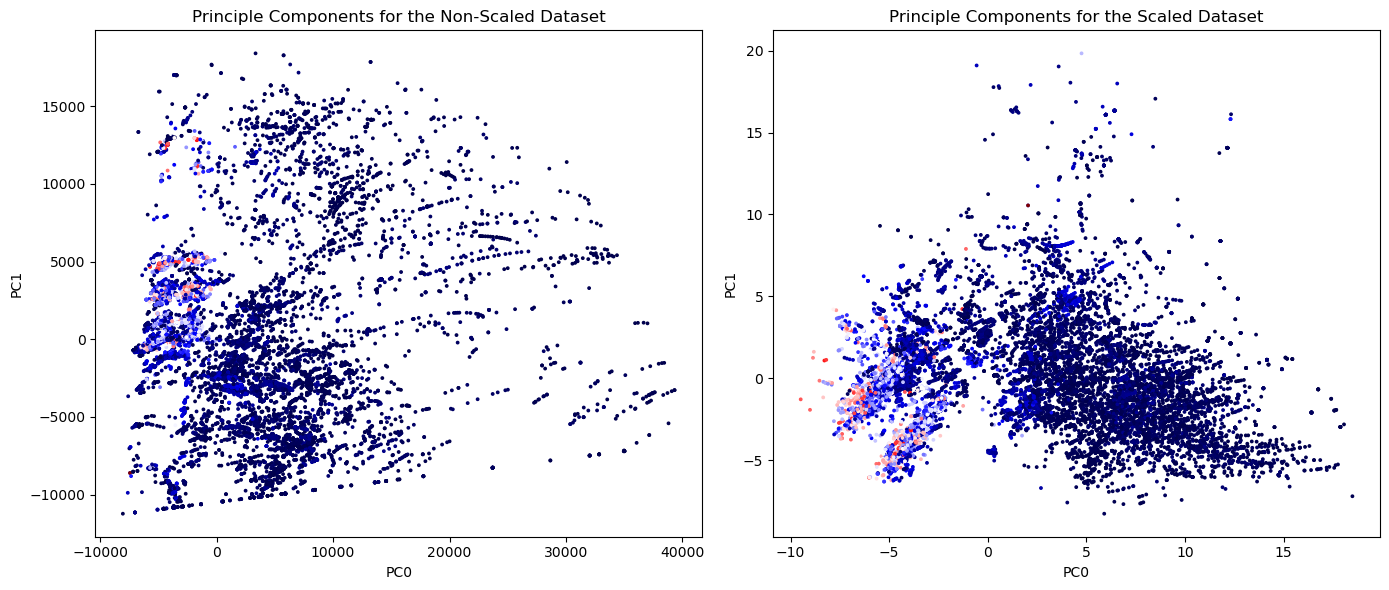

In [29]:
#plot 2 principal components ( of original dataset and scaled dataset )
f, ax = plt.subplots(1,2, figsize=(14,6))

X_train_reduced = PCA(n_components=0.9, svd_solver='full').fit_transform(X_train)
X_train_scaled_reduced = PCA(n_components=0.9, svd_solver='full').fit_transform(
    scaler.transform(X_train)
)

scatter(x = X_train_reduced[:, 0], y = X_train_reduced[:, 1], 
        c = y_train, ax = ax[0], xlabel = "PC0", ylabel = "PC1", 
        title = "Principle Components for the Non-Scaled Dataset")
scatter(x = X_train_scaled_reduced[:, 0], y = X_train_scaled_reduced[:, 1], 
        c = y_train, ax = ax[1], xlabel = "PC0", ylabel = "PC1", 
        title = "Principle Components for the Scaled Dataset")

f.tight_layout()

From the figure above, it seems that even though the original dataset has only $2$ components to explain $90\%$ of the variance, the scaled dataset clusters the data better with only $2$ of its $66$ components. 

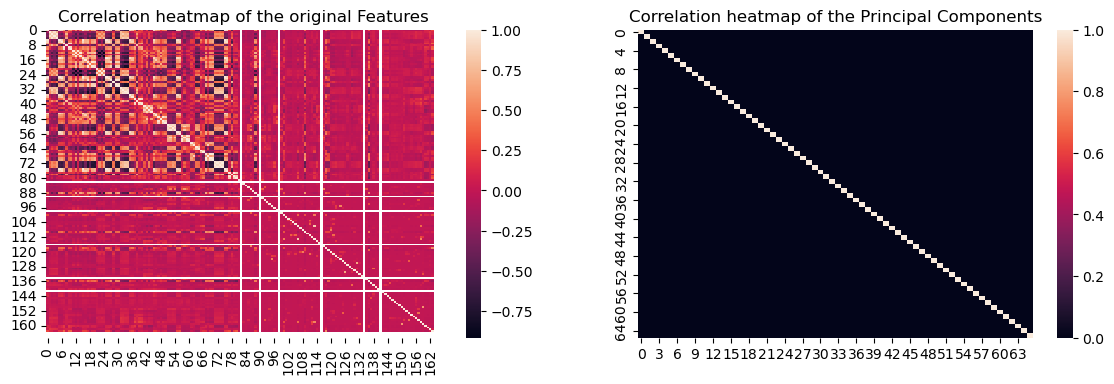

In [30]:
# check correlation of features (original dataset and reduced dataset)
f, ax = plt.subplots(1,2, figsize=(14,4))
sns.heatmap(
    np.corrcoef(scaler.transform(X_train).T), 
    ax=ax[0])
ax[0].set_title("Correlation heatmap of the original Features")
sns.heatmap(np.corrcoef(
                PCA(n_components=0.9, svd_solver="full").fit_transform(
                    scaler.transform(X_train)
                ).T), 
            ax=ax[1])
ax[1].set_title("Correlation heatmap of the Principal Components");

In the left plot we can see that in the full dataset there are some features that are redundant. It seems that some independent variables are related to others, as there are high correlation values.<br>
On the plot presented on the right, as expected, we can see that the components are not correlated with each other. 

## Objective 2 - Create a Regression and a Classification Model

### 2.1) Regression Model

For this part, we are making the regression model. We will be using Decision Trees (DT) and Linear Regression, with their sklearn implementation. Nonetheless, since PCA components are decorrolated between themselves, with no linear relation between components, we don't expect good performance from the Linear Regression (LR) model. <br>

In [31]:
# Create (and test the time) for the Regression Models (for full and reduced data)
t =time()
dtr = Pipeline([
    ("scaler", StandardScaler()),
    ("regressor", DecisionTreeRegressor())
]).fit(X_train, y_train)
print(f"Train time without PCA for DT = {time() - t:.3f}")

t=time()
lr = Pipeline([
    ("scaler", StandardScaler()),
    ("regressor", LinearRegression())
]).fit(X_train, y_train)
print(f"Train time without PCA for LR = {time() - t:.3f}")

t = time()
dtr_pca = Pipeline([
    ("scaler", StandardScaler()),
    ("dim", PCA(n_components=0.9, svd_solver="full")),
    ("regressor", DecisionTreeRegressor())
]).fit(X_train, y_train)
print(f"Train time with PCA for DT = {time() - t:.3f}")

t = time()
lr_pca = Pipeline([
    ("scaler", StandardScaler()),
    ("dim", PCA(n_components=0.9, svd_solver="full")),
    ("regressor", LinearRegression())
]).fit(X_train, y_train)
print(f"Train time with PCA for LR = {time() - t:.3f}")

Train time without PCA for DT = 2.801
Train time without PCA for LR = 0.231
Train time with PCA for DT = 2.773
Train time with PCA for LR = 0.382


We can see that PCA didn't create much overhead for both models. The complexity is mainly in training the tree model.

In [32]:
def scatter(y_test, preds, ax, ylabel="True Values", xlabel="Predicted Values", title=""):
    ax.scatter(preds,y_test, s=5)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.plot([0,140],[0,140], "r")
    ax.grid()

Prediction time for DT without PCA = 0.020
Prediction time for DT with PCA = 0.023
------------------------------------------------------------------------------------------------------------------------
Prediction time for LR without PCA = 0.012
Prediction time for LR with PCA = 0.022
------------------------------------------------------------------------------------------------------------------------
Full Dataset RMSE (DT) = 12.806 				 | Reduced Dataset RMSE (DT)= 12.990
Full Dataset Max. Error (DT) = 119.620 				 | Reduced Dataset Max. Error (DT) = 129.800
Full Dataset Pearson Corr. (DT) = 0.928 			 | Reduced Dataset Pearson Corr (DT)= 0.926

------------------------------------------------------------------------------------------------------------------------
Full Dataset RMSE (Linear Regression) = 17.010 			 | Reduced Dataset RMSE (Linear Regression) = 19.830
Full Dataset Max. Error (Linear Regression) = 78.703 		 | Reduced Dataset Max. Error (Linear Regression) = 128.488
Full

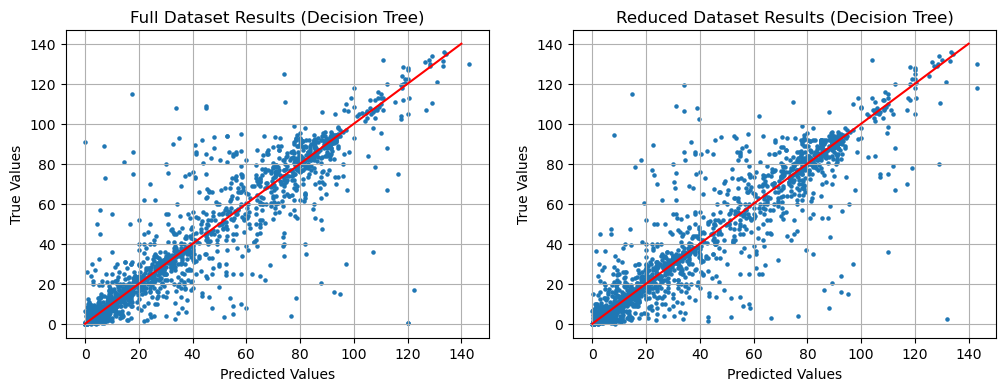

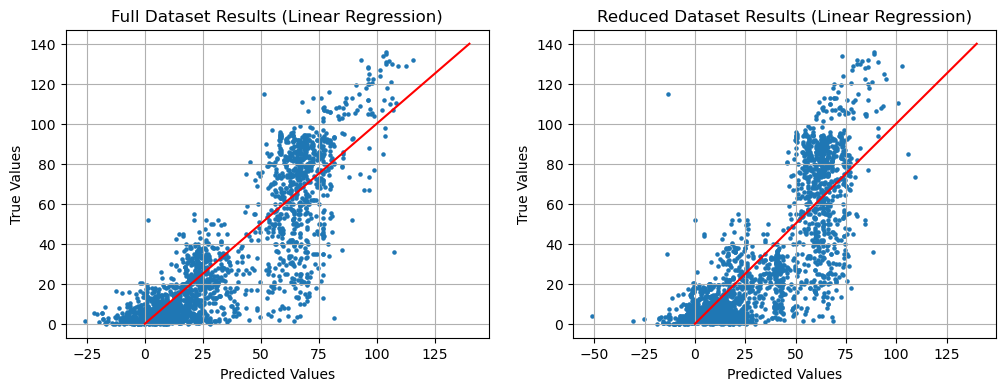

In [50]:
# Create (and check the time) for the Regression Models (for full and reduced data)
t = time()
preds = dtr.predict(X_test)
print(f"Prediction time for DT without PCA = {time() - t:.3f}")
t=time()
preds_pca = dtr_pca.predict(X_test)
print(f"Prediction time for DT with PCA = {time() - t:.3f}", end="\n"+"-"*120+"\n")
#now for LR
t = time()
preds_lr = lr.predict(X_test)
print(f"Prediction time for LR without PCA = {time() - t:.3f}")
t=time()
preds_lr_pca = lr_pca.predict(X_test)
print(f"Prediction time for LR with PCA = {time() - t:.3f}", end="\n"+"-"*120+"\n")

#Compute RMSE
rmse = mean_squared_error(y_test, preds, squared=False)
rmse_pca = mean_squared_error(y_test, preds_pca, squared=False)
# for LR
rmse_lr = mean_squared_error(y_test, preds_lr, squared=False)
rmse_lr_pca = mean_squared_error(y_test, preds_lr_pca, squared=False)

#Compute Maximum Error
max_err = max_error(y_test, preds)
max_err_pca = max_error(y_test, preds_pca)
#Compute Pearson Correlation between predictions and original data
pearson_r = np.corrcoef(y_test, preds)[0,1]
pearson_r_pca = np.corrcoef(y_test, preds_pca)[0,1]
#for LR
#Compute Maximum Error
max_err_lr = max_error(y_test, preds_lr)
max_err_lr_pca = max_error(y_test, preds_lr_pca)
#Compute Pearson Correlation between predictions and original data
pearson_r_lr = np.corrcoef(y_test, preds_lr)[0,1]
pearson_r_lr_pca = np.corrcoef(y_test, preds_lr_pca)[0,1]

print(f"Full Dataset RMSE (DT) = {rmse:.3f}", "\t"*4, 
      f"| Reduced Dataset RMSE (DT)= {rmse_pca:.3f}")
print(f"Full Dataset Max. Error (DT) = {max_err:.3f}", "\t"*4, 
      f"| Reduced Dataset Max. Error (DT) = {max_err_pca:.3f}")
print(f"Full Dataset Pearson Corr. (DT) = {pearson_r:.3f}", "\t"*3, 
      f"| Reduced Dataset Pearson Corr (DT)= {pearson_r_pca:.3f}")
f, ax = plt.subplots(1,2,figsize=(12,4))

scatter(y_test, preds, ax[0], title="Full Dataset Results (Decision Tree)")
scatter(y_test, preds_pca, ax[1],title="Reduced Dataset Results (Decision Tree)")

#for LR
print(f"", end="\n"+"-"*120+"\n")
print(f"Full Dataset RMSE (Linear Regression) = {rmse_lr:.3f}", "\t"*3, 
      f"| Reduced Dataset RMSE (Linear Regression) = {rmse_lr_pca:.3f}")
print(f"Full Dataset Max. Error (Linear Regression) = {max_err_lr:.3f}", "\t"*2, 
      f"| Reduced Dataset Max. Error (Linear Regression) = {max_err_lr_pca:.3f}")
print(f"Full Dataset Pearson Corr. (Linear Regression) = {pearson_r_lr:.3f}", "\t"*2, 
      f"| Reduced Dataset Pearson Corr. (Linear Regression) = {pearson_r_lr_pca:.3f}")

f, ax = plt.subplots(1,2,figsize=(12,4))
scatter(y_test, preds_lr, ax[0], title="Full Dataset Results (Linear Regression)")
scatter(y_test, preds_lr_pca, ax[1],title="Reduced Dataset Results (Linear Regression)")

In [34]:
print("Full dataset number of elements = ", np.prod(X_train.shape),
      "\nReduced dataset number of elements = ", np.prod(
            PCA(n_components=0.9, svd_solver="full").fit_transform(
                StandardScaler().fit_transform(X_train)
            ).shape))

Full dataset number of elements =  3195712 
Reduced dataset number of elements =  1262976


We can see that the regression difference is minimal using the full dataset or the reduced dataset. The statistical results are very similar, with no outsanding improvement or decrease in the performance. <br>

There is almost no overhead in the prediction time, adding the processing step of PCA data reduction. <br>

With this results, it is much better to use the reduced dataset, as the total size is reduced from $3195712$ elements to $1262976$, which is around $2.5$ less space, for the sampe prediction performance.

### 2.2) Classification Model

For this part, we are making the classification model. From the exercise, we were instructed to use both NaiveBayes (NB) and DecisionTrees (DT) for the full and reduced datasets. <br>

We will also have to create a few additional classes for the dependent variable. These will be VeryLow (0.0, 1.0), Low (0.0, 1.0), Medium (0.0, 1.0), High (0.0, 1.0) and VeryHigh (0.0, 1.0). We will then create two models, one with the full dataset (direct variables) and the other with the projection of the full data in a smaller data space (dimensionality reduction). These results will then be compared and discussed. <br>

We will compare the DT and NB using the full dataset for training. Afterwards we will compare both models using the reduced dataset. Finally we will compare the models that used the full dataset with the ones that used the reduced dataset

In [35]:
# Create a function to add classes
def to_class(x: float) -> str:
    if 0 <= x < 1.0:
        return "VeryLow"
    elif 1 <= x < 5.0:
        return "Low"
    elif 5 <= x < 20.0:
        return "Medium"
    elif 20 <= x < 100.0:
        return "High"
    elif x >= 100:
        return "VeryHigh"
    return np.nan

# Add classes to our dependent variable (apply function)
y_train_class = y_train.apply(to_class)
y_test_class = y_test.apply(to_class)

- Full Dataset 

In [36]:
# Create (and compare training time) for both models 
t = time()
dtc = Pipeline([
    ("scaler", StandardScaler()),
    ("classifier", DecisionTreeClassifier())
]).fit(X_train, y_train_class)
print(f"Decision Tree train time (no PCA) = {time() - t:.3f}")

t = time()
nb = Pipeline([
    ("scaler", StandardScaler()),
    ("classifier", GaussianNB())
]).fit(X_train, y_train_class)
print(f"Naive Bayes train time (no PCA) = {time() - t:.3f}")

Decision Tree train time (no PCA) = 3.775
Naive Bayes train time (no PCA) = 0.176


For this small dataset, we can already see big differences in the training time of Naive Bayes model and Decision Trees. This is a significant difference since the dataset is not that big. The difference will get bigger if the dataset size increases.

Decision Tree predict time (no PCA) = 0.014
Naive Bayes predict time (no PCA) = 0.053
Decision Tree MFCC = 0.766 					 | Naive Bayes MFCC = 0.243


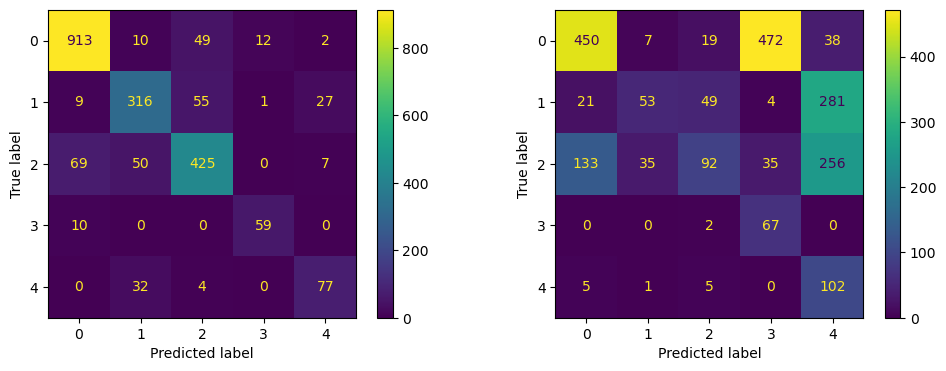

In [37]:
#Compare prediction time for both models 
t = time()
dtc_preds = dtc.predict(X_test)
print(f"Decision Tree predict time (no PCA) = {time() - t:.3f}")
t=time()
nb_preds = nb.predict(X_test)
print(f"Naive Bayes predict time (no PCA) = {time() - t:.3f}")

#Compute MFCC
dtc_mfcc = matthews_corrcoef(y_test_class,dtc_preds)
nb_mfcc= matthews_corrcoef(y_test_class, nb_preds)
print(f"Decision Tree MFCC = {dtc_mfcc:.3f}", "\t"*5,  f"| Naive Bayes MFCC = {nb_mfcc:.3f}")

#Plot confusion matrices
f, ax = plt.subplots(1,2, figsize=(12,4))
ConfusionMatrixDisplay(
    confusion_matrix(y_test_class, dtc_preds)
).plot(ax=ax[0]);

ConfusionMatrixDisplay(
    confusion_matrix(y_test_class, nb_preds)
).plot(ax=ax[1]);

We can see that the decision tree (DT) was actually faster making the predictions than naive bayes (NB). <br>
The DT model when making predictions only parses the Tree, which means complexity of $O(d)$, where $d$ is the depth of the tree. Parsing a tree is faster than calculating probabilities/likelihoods.

The DT also obtained better MFCC score and in the confusion matrix we can visualize why. As we have seen previously the features of the full dataset have high correlations. This could indicate some variable dependency, which is what NB discards, as it assumes the features are independent or maybe that the data is not normally distributed.

- Reduced Dataset

In [38]:
# Create (and compare training time) for both models 
t = time()
dtc = Pipeline([
    ("scaler", StandardScaler()),
    ("dim", PCA(n_components=0.9, svd_solver="full")),
    ("classifier", DecisionTreeClassifier())
]).fit(X_train, y_train_class)
print(f"Decision Tree train time (with PCA) = {time() - t:.3f}")

t = time()
nb = Pipeline([
    ("scaler", StandardScaler()),
    ("dim", PCA(n_components=0.9, svd_solver="full")),
    ("classifier", GaussianNB())
]).fit(X_train, y_train_class)
print(f"Naive Bayes train time (with PCA) = {time() - t:.3f}")

Decision Tree train time (with PCA) = 3.508
Naive Bayes train time (with PCA) = 0.455


We can see that reducing the dimension with PCA had a bigger impact in the NB model. While DT took the same time to train, NB took significant more time.

Decision Tree predict time (with PCA) = 0.021
Naive Bayes predict time (with PCA) = 0.026
Decision Tree MFCC = 0.747 					 | Naive Bayes MFCC = 0.168


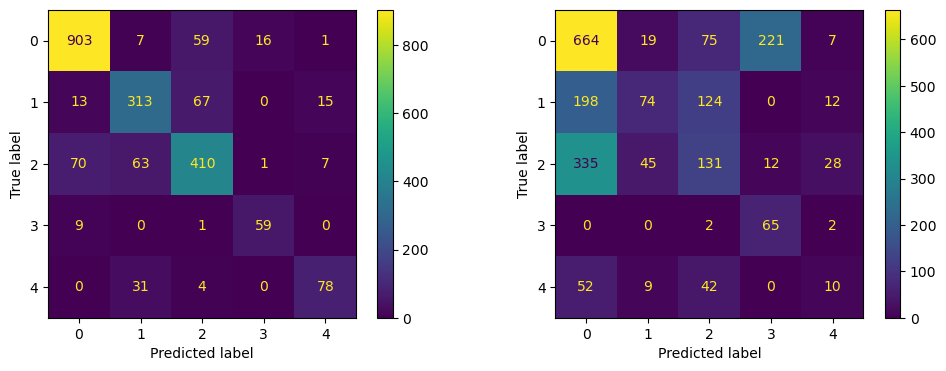

In [39]:
#Compare prediction time for both models 
t = time()
dtc_preds = dtc.predict(X_test)
print(f"Decision Tree predict time (with PCA) = {time() - t:.3f}")
t=time()
nb_preds = nb.predict(X_test)
print(f"Naive Bayes predict time (with PCA) = {time() - t:.3f}")

#Compute MFCC
dtc_mfcc = matthews_corrcoef(y_test_class,dtc_preds)
nb_mfcc= matthews_corrcoef(y_test_class, nb_preds)
print(f"Decision Tree MFCC = {dtc_mfcc:.3f}", "\t"*5,  f"| Naive Bayes MFCC = {nb_mfcc:.3f}")

#Plot confusion matrices
f, ax = plt.subplots(1,2, figsize=(12,4))
ConfusionMatrixDisplay(
    confusion_matrix(y_test_class, dtc_preds)
).plot(ax=ax[0]);

ConfusionMatrixDisplay(
    confusion_matrix(y_test_class, nb_preds)
).plot(ax=ax[1]);

Even with the independence of the variables, NB did not have a good performance, which could lead to our second hypothesis (features don't conform with a gaussian distribution). <br> 
Since DTs are universal function approximaters they performed better, as they can adapt more to every kind of relation in the data.

Comparing both decision trees, we see similar results on both datasets, like the scenario of the regression. Therefore, using the reduced dataset is advisable.